## Homework 4: due 2022/05/09 23:59 (100%)

### - Tutorial : 

1. Training on MNIST: https://www.kaggle.com/code/juiyangchang/cnn-with-pytorch-0-995-accuracy
2. Torchvision transforms: https://pytorch.org/vision/stable/transforms.html
3. Pytorch leraning rate scheduler: https://pytorch.org/docs/stable/optim.html
4. How to get learning rate: https://stackoverflow.com/questions/52660985/pytorch-how-to-get-learning-rate-during-training

### - After you go through the tutorials, you should be able to work on this assignment.

### - Please answer the following questions and work directly on this jupyter notebook.

### - Make sure the code can be run and show the result and figures properly.

### - Please write down your observation with markdown in this notebook briefly.



#### You will train a multi-class classfication model in this part. The data contains the images with three categories: cats, dogs and pandas. You can find the details of each column at https://www.kaggle.com/datasets/ashishsaxena2209/animal-image-datasetdog-cat-and-panda.

In [1]:
# Import necessory modules
%matplotlib inline
import os
import glob
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as tr
import torchvision.models as models
from torch.optim.lr_scheduler import MultiStepLR
import PIL.Image as Image
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from matplotlib.ticker import FormatStrFormatter

In [2]:
# For reproduce the result
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [3]:
# Download the dataset
!gdown --id 1tNKT8U4tsemnvU0HfRpPS-fth5a-8p-i --output ./animals.zip
# Unzip
!unzip animals.zip

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1tNKT8U4tsemnvU0HfRpPS-fth5a-8p-i
To: /content/animals.zip
100% 15.5M/15.5M [00:00<00:00, 276MB/s]
Archive:  animals.zip
replace animals/prediction/cats_00054.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### 1. Define the model and dataset (30%)

#### 1.1 Please create a class **AnimalDataset** for loading the data, and a varibale ***transform*** for the preprocessing transformation should be created for later usage.  (15%)

In [4]:
class AnimalDataset(Dataset):
    def __init__(self, path, transform=None):
        self.transform = transform
        # cats: 0, dogs: 1, panda: 2
        self.classes = os.listdir(path)
        self.images = []
        self.labels = []
        for i, cls in enumerate(self.classes):
            imagesPath = os.path.join(path, cls)
            images = glob.glob(os.path.join(imagesPath, '*.jpg'))
            self.images.extend(images)
            self.labels.extend([i] * len(images))

        self.images = np.array(self.images)
        self.labels = np.array(self.labels)
        print(f'Number of images is {len(self.images)}')
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        imgPath = self.images[idx]
        img = Image.open(imgPath)
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx].astype(torch.LongTensor)

#### 1.2 Please create a class **CNN** as your network with the architecture below. (15%)
##### (Note. Please determine the output layer by the task)

| Block 1 | Block 2 |  Fully Connected Layer |
|:---:|:---:|:---:|
| 3x3 conv, 64 | 3x3 conv, 128 |  Linear, 512 |
| ReLU         | ReLU   |Dropout(p=0.5)  |
| 2x2 MaxPooling, downsampling factor 2       | 2x2 MaxPooling, downsampling factor 2   | ReLU  |
|          |    |Linear, 256  |
|          |    |Dropout(p=0.5)  |
|          |    |ReLU |

In [5]:
class CNN(nn.Module):
    def __init__(self, nClasses):
        super(CNN, self).__init__()
        # input: 32x32x3
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # feature map: 8x8x128
        self.fc = nn.Sequential(
            nn.Linear(8 * 8 * 128, 512),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.Dropout(0.5),
            nn.ReLU(),
        )
        self.fc2 = nn.Linear(256, nClasses)
        
    def forward(self, X):
        X = self.block1(X)
        X = self.block2(X)
        X = torch.flatten(X, 1)
        X = self.fc(X)
        X = self.fc2(X)
        
        return X              

### 2. Train the model (70%)

#### 2.1 Please load the train/validation/test data from ***./animals*** respectively and resize the image to 32x32. For the data preprocessing, please apply ***RandomHorizontalFlip(p=0.5)*** and ***RandomRotation((-10,10))*** as data augmentations. Also, scale all the value in the range between 0 and 1 and normalize with mean value ***(0.485,0.456,0.406)*** and standard deviation ***(0.229,0.224,0.225)*** for RGB channel respectively. At last, create the DataLoaders with batch size 32.(10%)
##### (Note. The mean and standard deviation is calculated from ImageNet dataset) 

In [6]:
# Define the transform for the dataset
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]
trainTransform = tr.Compose([
    tr.Resize(size=(32, 32)),
    tr.RandomHorizontalFlip(p=0.5),
    tr.RandomRotation((-10, 10)),
    # ToTensor: convert PIL IMG [0,255], to the float tensor [0.0,1.0]
    tr.ToTensor(),
    tr.Normalize(means, stds)
])
 
# normally, we dont apply transform to test_set or val_set
valTransform = tr.Compose([
    tr.Resize(size=(32, 32)),
    tr.ToTensor(),
    tr.Normalize(means, stds)
])

# Load the train/validation/test
trainSet = AnimalDataset('./animals/train', transform=trainTransform)
valSet = AnimalDataset('./animals/val', transform=valTransform)
testSet = AnimalDataset('./animals/test', transform=valTransform)
trainLoader = DataLoader(trainSet, batch_size=32, shuffle=True)
valLoader = DataLoader(valSet, batch_size=32, shuffle=False)
testLoader = DataLoader(testSet, batch_size=32, shuffle=False)


Number of images is 1800
Number of images is 960
Number of images is 210


#### 2.2 Train the CNN model with the same hyperpameters below and do the validation every epoch. Choose the appropriate type of loss according to the task. Please record the learning rate, training/validation loss and training/validation accuracy every epoch. Also, save the model weights as ***model_without_scheduler.pth***(20%)


| | Learning rate | epochs | optimizer | weight decay | $\beta _1$|$\beta _2$|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|***Hyperparameter***| 5e-3 | 100 | Adam | 1e-2 | 0.9 | 0.99 |

In [7]:
def train(model, trainLoader, valLoader, nEpochs, device, criterion, optimizer, scheduler=None):
    overallLoss = np.zeros(nEpochs, dtype=np.float32)
    overallAcc = np.zeros(nEpochs, dtype=np.float32)
    overallValLoss = np.zeros(nEpochs, dtype=np.float32)
    overallValAcc = np.zeros(nEpochs, dtype=np.float32)
    overallLr = np.zeros(nEpochs, dtype=np.float32)
    bestAcc = 0

    model = model.to(device)
    for i in tqdm(range(nEpochs)):
        print(f'epoch = {i}')
        # epoch setting
        trainLoss = 0
        corrNum = 0
        
        # training part
        # start training
        model.train()
        for data, label in trainLoader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            loss = criterion(output, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            trainLoss += loss.item()
            # predict the label from the last layers' output. Choose index with the biggest probability 
            pred = output.argmax(dim=1)
            # correct if label == predict_label
            corrNum += (pred.eq(label.view_as(pred)).sum().item())
        
        if scheduler:
            # update scheduler for adjusting learning rate later
            scheduler.step()
            

        # averaging trainingLoss and calculate accuracy
        trainLoss = trainLoss / len(trainLoader.dataset) 
        trainAcc = corrNum / len(trainLoader.dataset)
        # record the training loss/acc
        overallLoss[i], overallAcc[i] = trainLoss, trainAcc
        # record the learning rate
        overallLr[i] = optimizer.param_groups[0]['lr']

        # validation part
        with torch.no_grad():
            model.eval()
            valLoss = 0
            corrNum = 0
            valAcc = 0
            for data, label in valLoader:
                data, label = data.to(device), label.to(device)
                output = model(data)
                loss = criterion(output, label)
                valLoss += loss.item()
                pred = output.argmax(dim=1)
                corrNum += (pred.eq(label.view_as(pred)).sum().item())
            
            valLoss = valLoss / len(valLoader.dataset)
            valAcc = corrNum / len(valLoader.dataset)
            overallValLoss[i], overallValAcc[i] = valLoss, valAcc
        

        # Display the results
        print(f'training loss : {trainLoss:.4f} ', f' train acc = {trainAcc:.4f}' )
        print(f'val loss : {valLoss:.4f} ', f' val acc = {valAcc:.4f}' )
        print("-----------------------------------------------------")

    

    # save the best model if it gain performance on validation set
    if valAcc > bestAcc:
        bestAcc = valAcc
        if scheduler:
            torch.save(model.state_dict(), 'model_with_scheduler.pth')
        else:
            torch.save(model.state_dict(), 'model_without_scheduler.pth')
        print('model saved')
    
    modelAcc = {"Training": overallAcc.tolist() , "Val": overallValAcc.tolist()}
    modelLoss = {"Training": overallLoss.tolist() , "Val": overallValLoss.tolist()}

    return modelAcc, modelLoss, overallLr.tolist()

def plotCurve(x, modelAcc, modelLoss, modelLr):
    # plot the learning curve, loss and acc for training and validation set
    fig, ax = plt.subplots(1, 3, figsize=(16,4))
    ax[0].plot(x, modelLr)
    ax[0].set_title('Learning Rate')
    ax[0].set_xlabel('Epoch')
    ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax[1].plot(x, modelLoss["Training"], label="Training Loss")
    ax[1].plot(x, modelLoss["Val"], label="Validation Loss")
    ax[1].set_title('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    ax[2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax[2].plot(x, modelAcc["Training"], label="Training Accuracy")
    ax[2].plot(x, modelAcc["Val"], label="Validation Accuracy")
    ax[2].set_title('Accuracy')
    ax[2].set_xlabel('Epoch')
    ax[2].set_ylabel('Accuracy')
    ax[2].legend()
    plt.show()

#### 2.3 Please draw the plot the learning rate, training/validation loss and training/validation accuracy and write down the observation. (10%)
##### (Example figure)
![image.png](https://github.com/tingyan08/Deep-Learning-and-Computer-Vision/blob/main/HW4/img/curve1.png?raw=true)

  0%|          | 0/100 [00:00<?, ?it/s]

epoch = 0
training loss : 0.0378   train acc = 0.4378
val loss : 0.0265   val acc = 0.5573
-----------------------------------------------------
epoch = 1
training loss : 0.0282   train acc = 0.5589
val loss : 0.0241   val acc = 0.5938
-----------------------------------------------------
epoch = 2
training loss : 0.0260   train acc = 0.5789
val loss : 0.0271   val acc = 0.5573
-----------------------------------------------------
epoch = 3
training loss : 0.0243   train acc = 0.5939
val loss : 0.0226   val acc = 0.6031
-----------------------------------------------------
epoch = 4
training loss : 0.0243   train acc = 0.5872
val loss : 0.0218   val acc = 0.6167
-----------------------------------------------------
epoch = 5
training loss : 0.0235   train acc = 0.5967
val loss : 0.0221   val acc = 0.6219
-----------------------------------------------------
epoch = 6
training loss : 0.0231   train acc = 0.6078
val loss : 0.0213   val acc = 0.6312
---------------------------------------

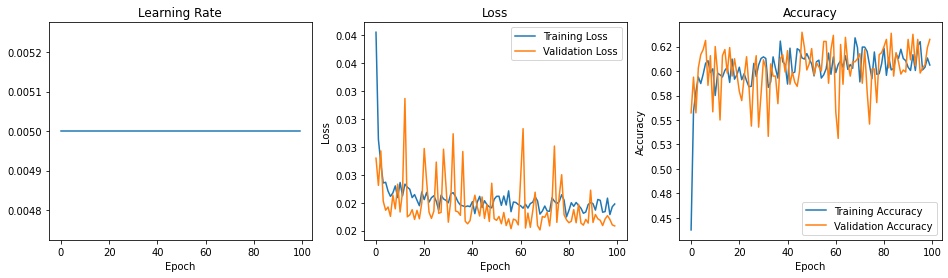

In [8]:
model = CNN(nClasses=len(trainSet.classes))
nEpochs = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
scheduler = None
optimizer = optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-2, betas=(0.9, 0.99))

(modelAcc, modelLoss, modelLr) = train(model=model,
                                         trainLoader=trainLoader,
                                         valLoader=valLoader,
                                         nEpochs=nEpochs,
                                         device=device,
                                         criterion=criterion,
                                         optimizer=optimizer,
                                         scheduler=scheduler)
                                         
x = np.arange(nEpochs)
plotCurve(x, modelAcc, modelLoss, modelLr)

#### 2.4 Please retrain model with learning rate decay with decreasing factor 0.1 at 20 epoch and 60 epoch. The other parameters are as same as last question. Also, redraw the learning rate, accuracy and loss curves and save the weights as ***model_with_scheduler.pth***. (10%)
##### (Example figure)
![image.png](https://github.com/tingyan08/Deep-Learning-and-Computer-Vision/blob/main/HW4/img/curve2.png?raw=true)

  0%|          | 0/100 [00:00<?, ?it/s]

epoch = 0
training loss : 0.0355   train acc = 0.4217
val loss : 0.0269   val acc = 0.5625
-----------------------------------------------------
epoch = 1
training loss : 0.0279   train acc = 0.5444
val loss : 0.0240   val acc = 0.6104
-----------------------------------------------------
epoch = 2
training loss : 0.0258   train acc = 0.5700
val loss : 0.0239   val acc = 0.5813
-----------------------------------------------------
epoch = 3
training loss : 0.0257   train acc = 0.5800
val loss : 0.0219   val acc = 0.6010
-----------------------------------------------------
epoch = 4
training loss : 0.0238   train acc = 0.5794
val loss : 0.0221   val acc = 0.6135
-----------------------------------------------------
epoch = 5
training loss : 0.0246   train acc = 0.5844
val loss : 0.0241   val acc = 0.5781
-----------------------------------------------------
epoch = 6
training loss : 0.0239   train acc = 0.6061
val loss : 0.0233   val acc = 0.5781
---------------------------------------

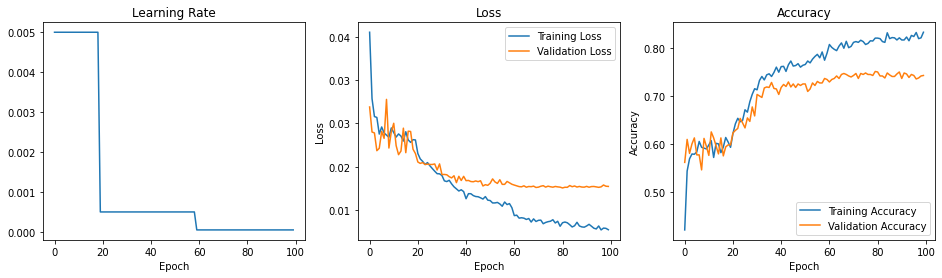

In [9]:
model = CNN(nClasses=len(trainSet.classes))
nEpochs = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-2, betas=(0.9, 0.99))
scheduler = MultiStepLR(optimizer, milestones=[20, 60], gamma=0.1)

(modelAcc, modelLoss, modelLr) = train(model=model,
                                         trainLoader=trainLoader,
                                         valLoader=valLoader,
                                         nEpochs=nEpochs,
                                         device=device,
                                         criterion=criterion,
                                         optimizer=optimizer,
                                         scheduler=scheduler)
                                         
x = np.arange(nEpochs)
plotCurve(x, modelAcc, modelLoss, modelLr)

#### 2.5 Please calculate the confusion matrix and print the accuracy of two models with the test dataset. (10%)
##### (Example figure)
![image.png](https://github.com/tingyan08/Deep-Learning-and-Computer-Vision/blob/main/HW4/img/confusion%20matrix.png?raw=true)

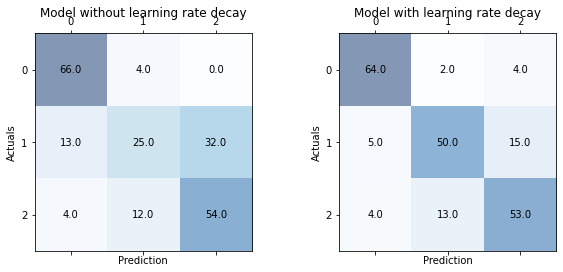

Model without learning rate decay decay accuracy: 0.6905
Model with learning rate decay accuracy: 0.7952


In [12]:
model1 = CNN(nClasses=len(trainSet.classes))
model1.load_state_dict(torch.load('./model_without_scheduler.pth'))
model1.to(device)
model2 = CNN(nClasses=len(trainSet.classes))
model2.load_state_dict(torch.load('./model_with_scheduler.pth'))
model2.to(device)
cfMat1 = torch.zeros(len(trainSet.classes), len(trainSet.classes))
cfMat2 = torch.zeros(len(trainSet.classes), len(trainSet.classes))

with torch.no_grad():
    model1.eval()
    model2.eval()
    for data, label in testLoader:
        data, label = data.to(device), label.to(device)
        pred = model1(data)
        pred = pred.argmax(dim=1)
        for t, p in zip(label, pred):
            cfMat1[t.item(), p.item()] += 1

        pred = model2(data)
        pred = pred.argmax(dim=1)
        for t, p in zip(label, pred):
            cfMat2[t.item(), p.item()] += 1

       
fig, ax = plt.subplots(1, 2, figsize=(10,4))
cfMat1 = cfMat1.cpu().numpy()
ax[0].matshow(cfMat1, cmap=plt.cm.Blues, alpha=0.5)
ax[0].set_title("Model without learning rate decay")
ax[0].set_xlabel("Prediction")
ax[0].set_ylabel("Actuals")
for r in range(cfMat1.shape[0]):
    for c in range(cfMat1.shape[1]):
        ax[0].text(c, r, cfMat1[r, c], va='center', ha='center')

cfMat2 = cfMat2.cpu().numpy()
ax[1].matshow(cfMat2, cmap=plt.cm.Blues, alpha=0.5)
ax[1].set_title("Model with learning rate decay")
ax[1].set_xlabel("Prediction")
ax[1].set_ylabel("Actuals")
for r in range(cfMat2.shape[0]):
    for c in range(cfMat2.shape[1]):
        ax[1].text(c, r, cfMat2[r, c], va='center', ha='center')
plt.show()

model1Acc = (np.trace(cfMat1) / np.sum(cfMat1))
model2Acc = (np.trace(cfMat2) / np.sum(cfMat2))
print(f"Model without learning rate decay decay accuracy: {model1Acc:.4f}")
print(f"Model with learning rate decay accuracy: {model2Acc:.4f}")


#### 2.6 Please choose the best model to predict the categories of images in the ***./animals/predict*** folder and show the figure with the prediction as title of each axes. (10%)
##### (Example figure)
![image.png](https://github.com/tingyan08/Deep-Learning-and-Computer-Vision/blob/main/HW4/img/img1.png?raw=true)

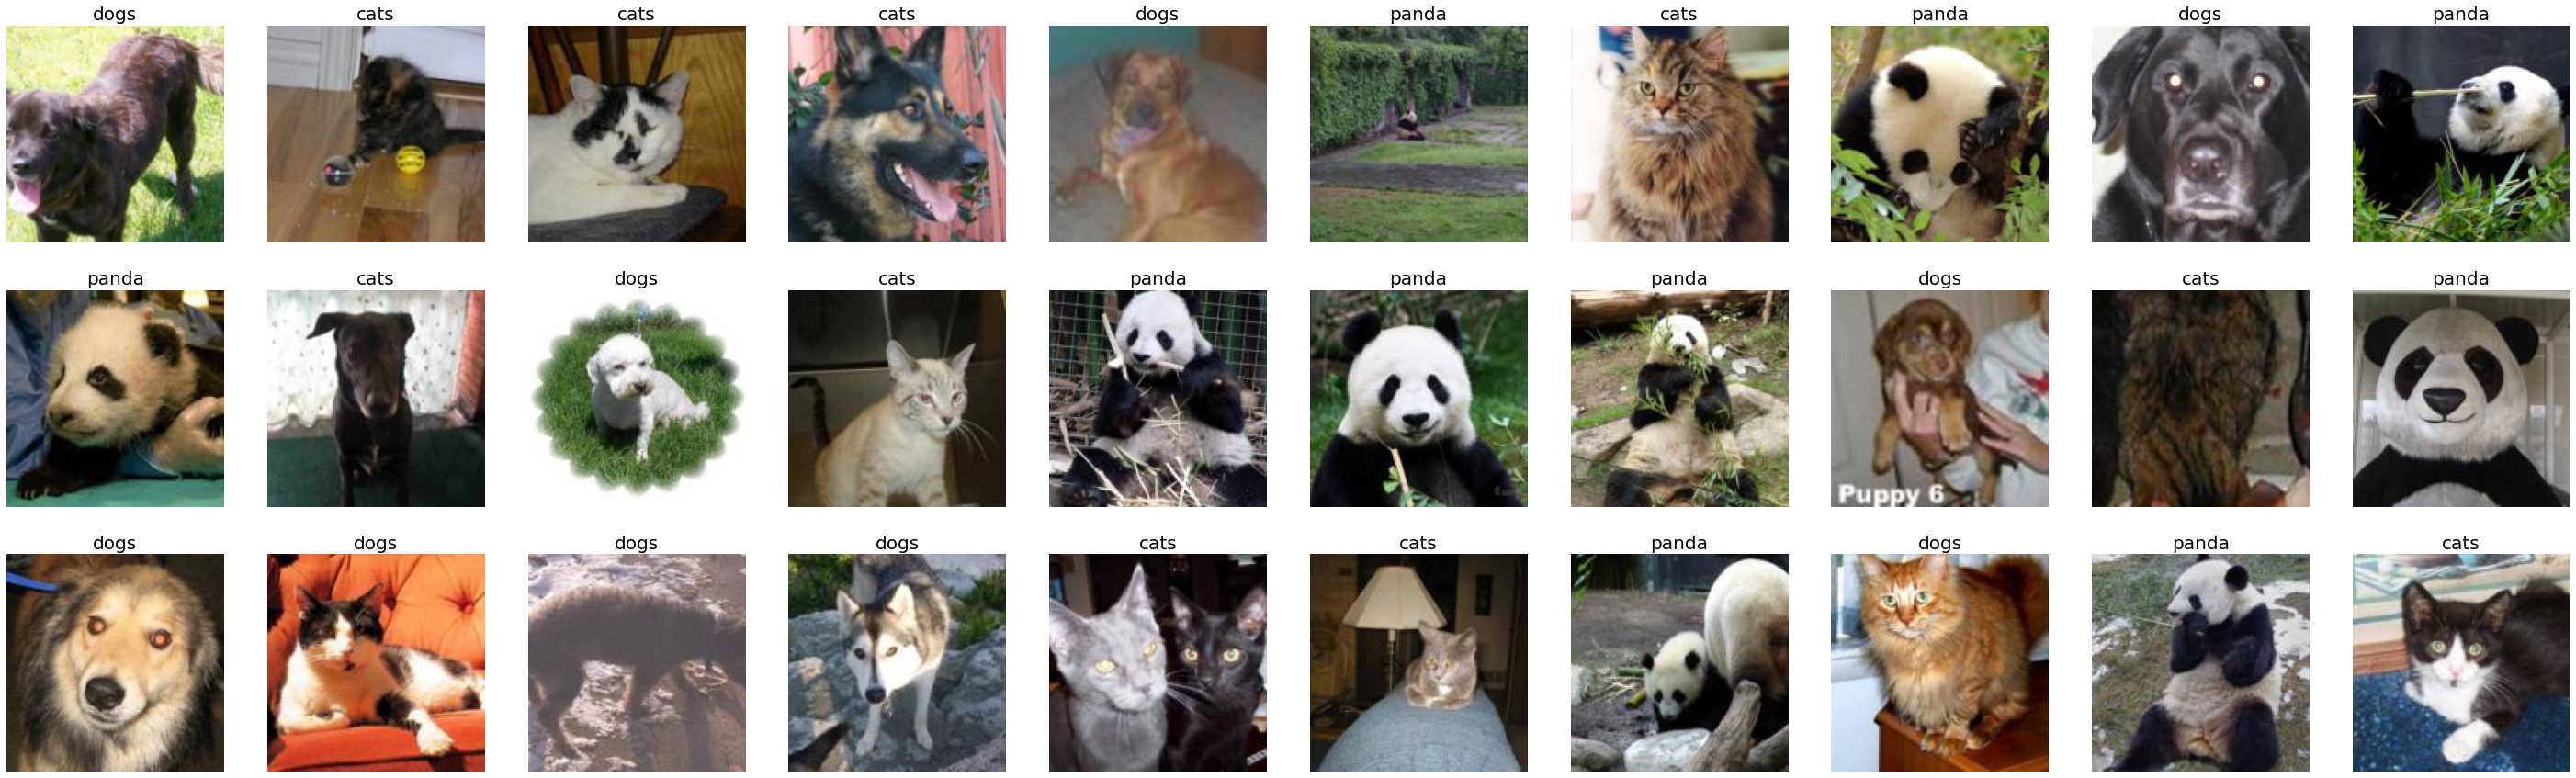

In [11]:
model3 = CNN(nClasses=len(trainSet.classes))
model3.load_state_dict(torch.load('./model_with_scheduler.pth'))
model3.to(device)

imageNames = glob.glob(os.path.join("./animals/prediction", "*.jpg"))
images = [Image.open(imageName) for imageName in imageNames]
predictions = []
for image in images:
    data = testSet.transform(image)
    data = data.unsqueeze(0)
    with torch.no_grad():
        model3.eval()
        data = data.to(device)
        pred = model3(data)
        pred = pred.argmax(dim=1)
        predictions.append(pred.item())
        
fig, ax = plt.subplots(3, 10, figsize = (50,15))
for i, (img, pred) in enumerate(zip(images, predictions)):
    ax[i//10][i%10].imshow(img)
    ax[i//10][i%10].set_title(testSet.classes[pred], fontsize = 20)
    ax[i//10][i%10].axis("off")
plt.show()